# Setup

In [1]:
import pandas as pd
import numpy as np
import random
import transformers
import torch
import dotenv
import os
import matplotlib.pyplot as plt
import re

dotenv.load_dotenv()

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto",
    token=os.getenv('HF_TOKEN')
)

terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Testing infrastructure, v1

In [3]:
def make_problem(digits, format=None):
    if format is None:
        n = random.randint(10**(digits-1), 10**digits-1)
        return str(n), n
    elif format[0] == '+':
        p1 = make_problem(digits, format[1][0])
        p2 = make_problem(digits, format[1][1])
        return f"({p1[0]}+{p2[0]})", p1[1] + p2[1]
    elif format[0] == '-':
        p1 = make_problem(digits, format[1][0])
        p2 = make_problem(digits, format[1][1])
        return f"({p1[0]}-{p2[0]})", p1[1] - p2[1]
    elif format[0] == '*':
        p1 = make_problem(digits, format[1][0])
        p2 = make_problem(digits, format[1][1])
        return f"({p1[0]}*{p2[0]})", p1[1] * p2[1]
    
def make_problem_set(digits, format, num_problems):
    return pd.DataFrame([make_problem(digits, format) for _ in range(num_problems)], columns=['problem', 'correct_solution'])

In [4]:
def solve_problem_cot(problem, sys_prompt, cot_prompt):
    messages = [
    {"role": "system", "content": sys_prompt + ' ' + cot_prompt},
    {"role": "user", "content": problem},
    ]

    outputs = pipeline(
    messages,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
    pad_token_id=pipeline.tokenizer.eos_token_id
    )

    return outputs[0]['generated_text'][-1]['content']

def solve_problem_set_cot(problem_set, sys_prompt, cot_prompt):
    solved = problem_set.copy()
    solved['solution'] = [solve_problem_cot(row['problem'], sys_prompt, cot_prompt) for _, row in problem_set.iterrows()]
    return solved

def solve_problem_fp(problem, sys_prompt, fp_prompt, max_toks=10): # setting max_toks to 1 because we're doing small digit numbers
    messages = [
    {"role": "system", "content": sys_prompt + ' ' + fp_prompt},
    {"role": "user", "content": problem},
    ]

    outputs = pipeline(
    messages,
    max_new_tokens=max_toks,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
    pad_token_id=pipeline.tokenizer.eos_token_id
    )

    return outputs[0]['generated_text'][-1]['content']

def solve_problem_set_fp(problem_set, sys_prompt, fp_prompt):
    solved = problem_set.copy()
    solved['solution'] = [solve_problem_fp(row['problem'], sys_prompt=sys_prompt, fp_prompt=fp_prompt) for _, row in problem_set.iterrows()]
    return solved

In [5]:
def correct_rate(solution_set):
    df_with_correct = solution_set.copy()
    df_with_correct['correct'] = df_with_correct.apply(lambda x: str(x['correct_solution']) in re.sub(r'[^0-9]+', '', x['solution']), axis=1)
    return df_with_correct

In [6]:
def bernoulli_std(mean, samples):
    return np.sqrt((mean*(1-mean))/samples)

def do_full_test(digits, format, sys_prompt, cot_prompt, fp_prompt, n):
    df = make_problem_set(digits, format, n)
    df_cot = solve_problem_set_cot(df, sys_prompt, cot_prompt)
    df_cot = correct_rate(df_cot)
    df_fp = solve_problem_set_fp(df, sys_prompt, fp_prompt)
    df_fp = correct_rate(df_fp)
    cot_mean = sum(df_cot['correct'])/n
    fp_mean = sum(df_fp['correct'])/n
    print(f"COT accuracy: {cot_mean} +- {2*bernoulli_std(cot_mean, n):.3f}\nFP accuracy: {fp_mean} +- {2*bernoulli_std(fp_mean, n):.3f}")
    return df_cot, df_fp
    

In [7]:
task_p = 'What is the value of this expression?'
cot_p_add = 'Think through your answer carefully, and show all your work.'
cot_p_mul = 'Think through your answer carefully, and show all your work.'
fp_p = 'Answer with only a number.'

n_samples = 50

In [8]:
results_add = []

for n in range(1, 20):
    results_add.append(do_full_test(n,
             ('+', (None, None)),
             task_p,
             cot_p_add,
             fp_p,
             n_samples))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


COT accuracy: 1.0 +- 0.000
FP accuracy: 1.0 +- 0.000
COT accuracy: 1.0 +- 0.000
FP accuracy: 1.0 +- 0.000
COT accuracy: 1.0 +- 0.000
FP accuracy: 1.0 +- 0.000
COT accuracy: 0.94 +- 0.067
FP accuracy: 0.96 +- 0.055
COT accuracy: 0.88 +- 0.092
FP accuracy: 0.82 +- 0.109
COT accuracy: 0.84 +- 0.104
FP accuracy: 0.88 +- 0.092
COT accuracy: 0.54 +- 0.141
FP accuracy: 0.14 +- 0.098
COT accuracy: 0.38 +- 0.137
FP accuracy: 0.54 +- 0.141
COT accuracy: 0.4 +- 0.139
FP accuracy: 0.58 +- 0.140
COT accuracy: 0.2 +- 0.113
FP accuracy: 0.34 +- 0.134
COT accuracy: 0.24 +- 0.121
FP accuracy: 0.26 +- 0.124
COT accuracy: 0.22 +- 0.117
FP accuracy: 0.46 +- 0.141
COT accuracy: 0.02 +- 0.040
FP accuracy: 0.36 +- 0.136
COT accuracy: 0.16 +- 0.104
FP accuracy: 0.12 +- 0.092
COT accuracy: 0.24 +- 0.121
FP accuracy: 0.18 +- 0.109
COT accuracy: 0.08 +- 0.077
FP accuracy: 0.16 +- 0.104
COT accuracy: 0.08 +- 0.077
FP accuracy: 0.02 +- 0.040
COT accuracy: 0.12 +- 0.092
FP accuracy: 0.08 +- 0.077
COT accuracy: 0.02

In [9]:
results_mul = []

for n in range(1, 5):
    results_mul.append(do_full_test(n,
             ('*', (None, None)),
             task_p,
             cot_p_add,
             fp_p,
             n_samples))

COT accuracy: 1.0 +- 0.000
FP accuracy: 1.0 +- 0.000
COT accuracy: 0.78 +- 0.117
FP accuracy: 0.68 +- 0.132
COT accuracy: 0.14 +- 0.098
FP accuracy: 0.04 +- 0.055
COT accuracy: 0.0 +- 0.000
FP accuracy: 0.0 +- 0.000


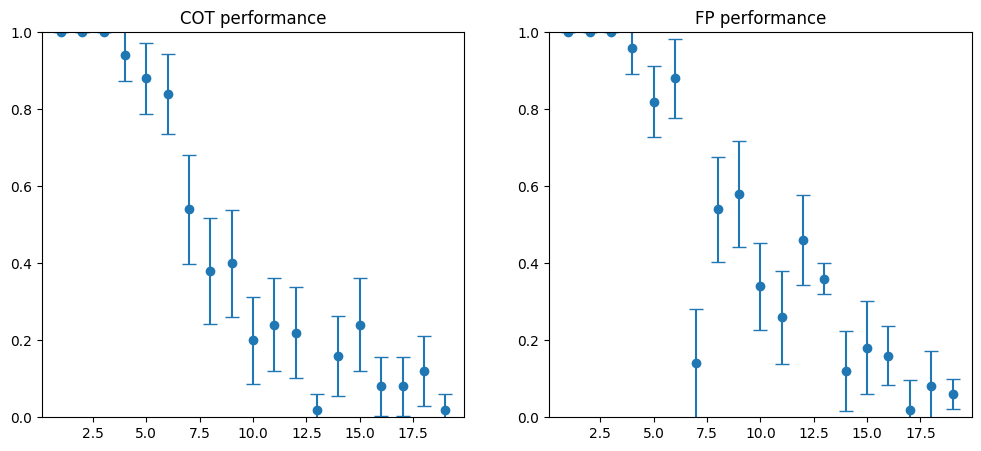

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.errorbar(
    x = range(1, len(results_add)+1),
    y = [sum(df_cot['correct'])/n_samples for df_cot, _ in results_add],
    yerr = [2*bernoulli_std(sum(df_cot['correct'])/n_samples, n_samples) for df_cot, _ in results_add],
    linestyle='',
    fmt='o',
    capsize=5
)
ax1.set_title('COT performance')
ax1.set_ylim(0, 1)
ax2.errorbar(
    x = range(1, len(results_add)+1),
    y = [sum(df_fp['correct'])/n_samples for _, df_fp in results_add],
    yerr = [2*bernoulli_std(sum(df_fp['correct'])/n_samples, n_samples) for df_fp, _ in results_add],
    linestyle='',
    fmt='o',
    capsize=5
)
ax2.set_title('FP performance')
ax2.set_ylim(0, 1)
plt.show()

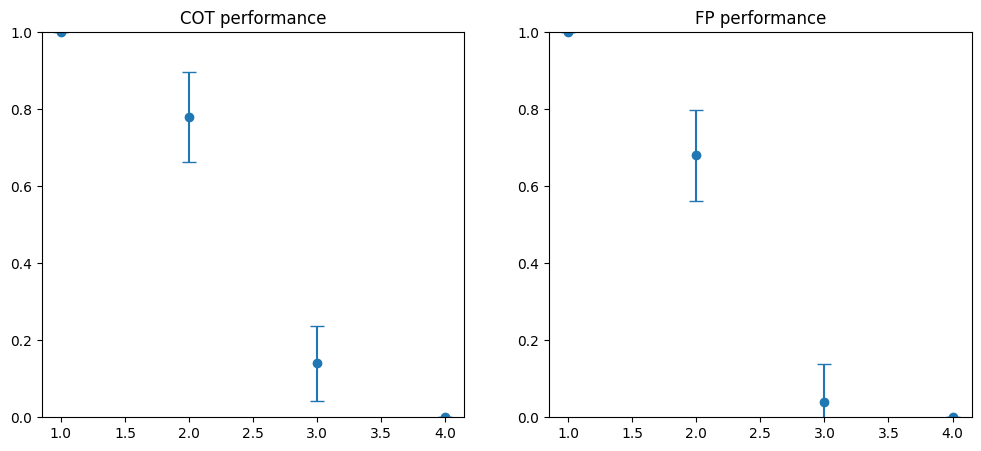

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.errorbar(
    x = range(1, len(results_mul)+1),
    y = [sum(df_cot['correct'])/n_samples for df_cot, _ in results_mul],
    yerr = [2*bernoulli_std(sum(df_cot['correct'])/n_samples, n_samples) for df_cot, _ in results_mul],
    linestyle='',
    fmt='o',
    capsize=5
)
ax1.set_title('COT performance')
ax1.set_ylim(0, 1)
ax2.errorbar(
    x = range(1, len(results_mul)+1),
    y = [sum(df_fp['correct'])/n_samples for _, df_fp in results_mul],
    yerr = [2*bernoulli_std(sum(df_fp['correct'])/n_samples, n_samples) for df_fp, _ in results_mul],
    linestyle='',
    fmt='o',
    capsize=5
)
ax2.set_title('FP performance')
ax2.set_ylim(0, 1)
plt.show()

# Testing infrastructure v2

In [12]:
from math import sqrt
def wilson(p, n, z = 1.96):
    denominator = 1 + z**2/n
    centre_adjusted_probability = p + z*z / (2*n)
    adjusted_standard_deviation = sqrt((p*(1 - p) + z*z / (4*n)) / n)

    lower_bound = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
    upper_bound = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator
    return (max(p-lower_bound, 0), max(upper_bound-p, 0))

def do_fuller_test(digits_range, format, sys_prompt, cot_prompt, fp_prompt, n_samples):
    results = []
    cot_conf_ints = []
    fp_conf_ints = []
    for digits in digits_range:
        df = make_problem_set(digits, format, n_samples)

        df_cot = solve_problem_set_cot(df, sys_prompt, cot_prompt)
        df_cot = correct_rate(df_cot)
        cot_mean = sum(df_cot['correct'])/n_samples
        cot_lower, cot_upper = wilson(cot_mean, n_samples)
        cot_conf_ints.append((cot_lower, cot_upper))
        print(f"COT accuracy: between {cot_mean-cot_lower} and {cot_mean+cot_upper}")
        
        df_fp = solve_problem_set_fp(df, sys_prompt, fp_prompt)
        df_fp = correct_rate(df_fp)
        fp_mean = sum(df_fp['correct'])/n_samples
        fp_lower, fp_upper = wilson(fp_mean, n_samples)
        fp_conf_ints.append((fp_lower, fp_upper))
        print(f"FP accuracy: between {fp_mean-fp_lower} and {fp_mean+fp_upper}")

        results.append((df_cot, df_fp))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.errorbar(
        x = range(1, len(results)+1),
        y = [sum(df_cot['correct'])/n_samples for df_cot, _ in results],
        yerr = [[x[0] for x in cot_conf_ints], [x[1] for x in cot_conf_ints]],
        linestyle='',
        fmt='o',
        capsize=5
    )
    ax1.set_title('COT performance')
    ax1.set_xticks(range(1, len(results)+1))
    ax1.set_xlabel('Number of digits')
    ax1.set_ylim(0, 1)
    ax1.set_ylabel('Proportion Correct')
    ax2.errorbar(
        x = range(1, len(results)+1),
        y = [sum(df_fp['correct'])/n_samples for _, df_fp in results],
        yerr = [[x[0] for x in fp_conf_ints], [x[1] for x in fp_conf_ints]],
        linestyle='',
        fmt='o',
        capsize=5
    )
    ax2.set_title('Memorization performance')
    ax2.set_xticks(range(1, len(results)+1))
    ax2.set_xlabel('Number of digits')
    ax2.set_ylim(0, 1)
    ax2.set_ylabel('Proportion Correct')
    plt.show()
    return results

COT accuracy: between 0.963005192523998 and 1.0
FP accuracy: between 0.06254131955225124 and 0.18631463027903025
COT accuracy: between 0.963005192523998 and 1.0
FP accuracy: between 0.005501852234968177 and 0.07001316294199365
COT accuracy: between 0.8752303146877749 and 0.9722142547333434
FP accuracy: between 0.0 and 0.03699480747600191
COT accuracy: between 0.5627754565831095 and 0.74538620502457
FP accuracy: between 0.0 and 0.03699480747600191
COT accuracy: between 0.4920125056109662 and 0.6813284290433533
FP accuracy: between 0.0 and 0.03699480747600191


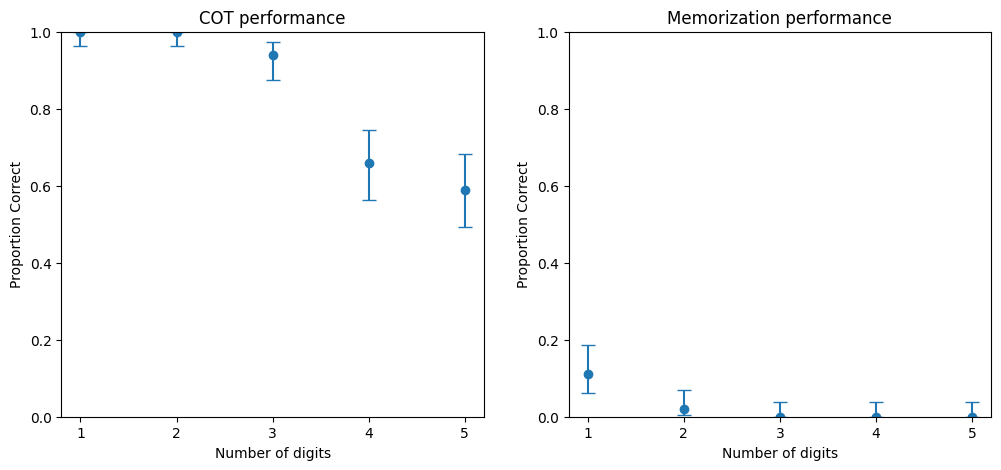

In [13]:
r = do_fuller_test(range(1, 6), ('+', (('+', (None, None)), ('+', (None, None)))), task_p, 'Think carefully and show all your work.', 'Answer with only a number.', 100)

In [14]:
for df_cot, df_fp in r:
    cot_mean = sum(df_cot['correct'])/100
    fp_mean = sum(df_fp['correct'])/100
    print(f"COT mean: {cot_mean}\nFP mean: {fp_mean}")

COT mean: 1.0
FP mean: 0.11
COT mean: 1.0
FP mean: 0.02
COT mean: 0.94
FP mean: 0.0
COT mean: 0.66
FP mean: 0.0
COT mean: 0.59
FP mean: 0.0


# 2-nested addition gets good scores for 1, 2, and 3 digits.

# prompt sensitivity validation testing
making sure it's not possible to elicit better memorization performance with prompt variation

In [15]:
task_prompts = [
    'What is the value of this expression?',
    'What does this arithmetic expression evaluate to?',
    'calculate the result of the following arithmetic expression',
    ' Solve this arithmetic expression.',
    '\nCompute the value of this expression.'
]
cot_prompts = [
    'Think through your answer carefully, and show all your work.',
    'Please think through the steps as you solve this expression, and explain your reasoning',
    'explain your calculations step-by-step as you solve this arithmetic expression.',
    ' Break down your approach to solving this expression, explaining your reasoning along the way',
    '\nThink aloud as you solve this expression, showing how you reason through it.'
]
fp_prompts = [
    'Answer with only a number.',
    'Provide just the numerical answer for this expression',
    'do not show any of your work.',
    ' Respond with just the number please',
    '\nRespond immediately with only the final numerical value.',
]

n_samples_check= 50
check_results = []
for i, task_prompt in enumerate(task_prompts):
    for j, cot_prompt in enumerate(cot_prompts):
        for k, fp_prompt in enumerate(fp_prompts):
            check_results.append([i,j,k])
            cot, fp = do_full_test(2,
             ('+', (('+', (None, None)), ('+', (None, None)))),
             task_prompt,
             cot_prompt,
             fp_prompt,
             n_samples_check)
            check_results[-1].append(sum(correct_rate(fp)['correct'])/n_samples_check)
            check_results[-1].append(sum([x.isnumeric() for x in fp['solution']]))
check_results = pd.DataFrame(check_results, columns=['task', 'cot', 'fp', 'fp_correct', 'fp_numeric'])

COT accuracy: 1.0 +- 0.000
FP accuracy: 0.02 +- 0.040
COT accuracy: 1.0 +- 0.000
FP accuracy: 0.0 +- 0.000
COT accuracy: 1.0 +- 0.000
FP accuracy: 0.04 +- 0.055
COT accuracy: 1.0 +- 0.000
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.98 +- 0.040
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.98 +- 0.040
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.98 +- 0.040
FP accuracy: 0.02 +- 0.040
COT accuracy: 1.0 +- 0.000
FP accuracy: 0.04 +- 0.055
COT accuracy: 1.0 +- 0.000
FP accuracy: 0.0 +- 0.000
COT accuracy: 1.0 +- 0.000
FP accuracy: 0.02 +- 0.040
COT accuracy: 1.0 +- 0.000
FP accuracy: 0.0 +- 0.000
COT accuracy: 1.0 +- 0.000
FP accuracy: 0.02 +- 0.040
COT accuracy: 1.0 +- 0.000
FP accuracy: 0.02 +- 0.040
COT accuracy: 1.0 +- 0.000
FP accuracy: 0.02 +- 0.040
COT accuracy: 1.0 +- 0.000
FP accuracy: 0.02 +- 0.040
COT accuracy: 1.0 +- 0.000
FP accuracy: 0.0 +- 0.000
COT accuracy: 1.0 +- 0.000
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.98 +- 0.040
FP accuracy: 0.04 +- 0.055
COT accuracy: 1.0 +- 0.000
FP ac

In [16]:
check_results.groupby('fp')['fp_numeric'].mean() # are these results actually numeric?

fp
0    50.00
1    49.12
2    48.60
3    50.00
4    50.00
Name: fp_numeric, dtype: float64

Text(0, 0.5, 'Count')

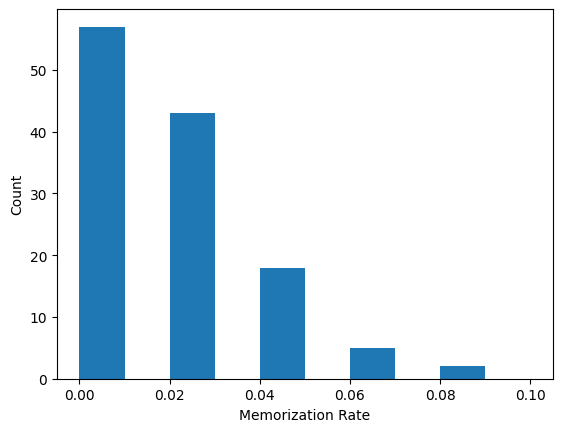

In [27]:
plt.hist(check_results.groupby(['task', 'cot', 'fp'])['fp_correct'].mean(), bins=np.arange(0, 0.11, 0.01)) # how's the memorization performance?
plt.xlabel('Memorization Rate')
plt.ylabel('Count')

In [25]:
check_results['fp_correct'].mean()

0.01632

In [29]:
check_results.loc[check_results['fp_correct'] == max(check_results['fp_correct'])]

,task,cot,fp,fp_correct,fp_numeric
107,4,1,2,0.08,46
117,4,3,2,0.08,47


In [30]:
do_full_test(2,
             ('+', (('+', (None,None)),('+', (None,None)))),
             task_prompts[4],
             cot_prompts[0],
             fp_prompts[2],
             100)

COT accuracy: 1.0 +- 0.000
FP accuracy: 0.07 +- 0.051


(              problem  correct_solution  \
 0   ((76+78)+(31+94))               279   
 1   ((97+57)+(91+40))               285   
 2   ((12+84)+(83+28))               207   
 3   ((99+82)+(75+13))               269   
 4   ((31+23)+(48+44))               146   
 ..                ...               ...   
 95  ((97+20)+(43+89))               249   
 96  ((27+86)+(66+60))               239   
 97  ((75+63)+(72+38))               248   
 98  ((50+18)+(69+73))               210   
 99  ((96+80)+(87+54))               317   
 
                                              solution  correct  
 0   To evaluate this expression, I'll follow the o...     True  
 1   To evaluate this expression, I'll follow the o...     True  
 2   To evaluate this expression, I'll follow the o...     True  
 3   To evaluate this expression, I'll follow the o...     True  
 4   To evaluate this expression, I'll follow the o...     True  
 ..                                                ...      ...  
 95  To 

# Found a prompt set that gets ~7% memorization performance. Checking 3-digit

In [31]:
do_full_test(3,
             ('+', (('+', (None,None)),('+', (None,None)))),
             task_prompts[4],
             cot_prompts[0],
             fp_prompts[2],
             200)

COT accuracy: 0.97 +- 0.024
FP accuracy: 0.015 +- 0.017


(                   problem  correct_solution  \
 0    ((720+707)+(618+386))              2431   
 1    ((945+720)+(105+845))              2615   
 2    ((426+275)+(933+854))              2488   
 3    ((169+414)+(891+694))              2168   
 4    ((138+319)+(396+758))              1611   
 ..                     ...               ...   
 195  ((314+298)+(519+939))              2070   
 196  ((436+332)+(260+927))              1955   
 197  ((591+983)+(493+681))              2748   
 198  ((575+688)+(195+408))              1866   
 199  ((364+186)+(858+773))              2181   
 
                                               solution  correct  
 0    To evaluate this expression, I'll follow the o...    False  
 1    To evaluate this expression, I'll follow the o...     True  
 2    To evaluate this expression, we need to follow...     True  
 3    To evaluate this expression, I'll follow the o...     True  
 4    To evaluate this expression, I'll follow the o...     True  
 ..     

In [33]:
for cot_prompt in cot_prompts: # checking for more performant 3-digit cot prompts
    _ = do_full_test(3,
             ('+', (('+', (None,None)),('+', (None,None)))),
             task_prompts[4],
             cot_prompts[0],
             fp_prompts[2],
             100)

COT accuracy: 0.95 +- 0.044
FP accuracy: 0.02 +- 0.028
COT accuracy: 0.96 +- 0.039
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.98 +- 0.028
FP accuracy: 0.02 +- 0.028
COT accuracy: 0.95 +- 0.044
FP accuracy: 0.04 +- 0.039
COT accuracy: 0.94 +- 0.047
FP accuracy: 0.01 +- 0.020


In [36]:
# double-checking in case some other prompt combo has better memorization on 3-digit
check_results_3 = []
n_samples_check = 50
for i, task_prompt in enumerate(task_prompts):
    for k, fp_prompt in enumerate(fp_prompts):
        check_results_3.append([i,j,k])
        cot, fp = do_full_test(3,
            ('+', (('+', (None, None)), ('+', (None, None)))),
            task_prompt,
            cot_prompts[2],
            fp_prompt,
            n_samples_check)
        check_results_3[-1].append(sum(correct_rate(fp)['correct'])/n_samples_check)
        check_results_3[-1].append(sum([x.isnumeric() for x in fp['solution']]))
check_results_3 = pd.DataFrame(check_results_3, columns=['task', 'cot', 'fp', 'fp_correct', 'fp_numeric'])

COT accuracy: 0.9 +- 0.085
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.9 +- 0.085
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.88 +- 0.092
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.96 +- 0.055
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.94 +- 0.067
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.94 +- 0.067
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.98 +- 0.040
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.9 +- 0.085
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.92 +- 0.077
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.94 +- 0.067
FP accuracy: 0.02 +- 0.040
COT accuracy: 0.88 +- 0.092
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.94 +- 0.067
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.88 +- 0.092
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.92 +- 0.077
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.92 +- 0.077
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.94 +- 0.067
FP accuracy: 0.0 +- 0.000
COT accuracy: 0.94 +- 0.067
FP accuracy: 0.02 +- 0.040
COT accuracy: 0.88 +- 0.092
FP accuracy: 0.02 +- 0.040
COT accuracy: 0.96 +- 0.055


Text(0, 0.5, 'Count')

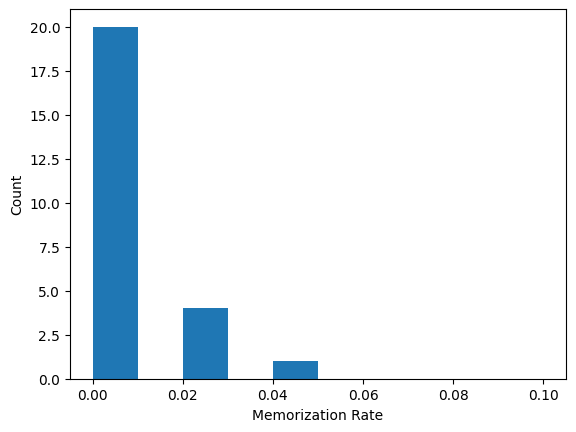

In [37]:
plt.hist(check_results_3.groupby(['task', 'cot', 'fp'])['fp_correct'].mean(), bins=np.arange(0, 0.11, 0.01)) # how's the memorization performance?
plt.xlabel('Memorization Rate')
plt.ylabel('Count')

In [40]:
check_results_3['fp_correct'].mean()

0.0048

# Final step: making the problem set

2-digit nested addition gets ~99% COT accuracy and max 8% memorization accuracy, 1.6% on average.

2-digit nested addition gets ~98% COT accuracy and max 5% memorization accuracy, 0.5% on average.

In [41]:
make_problem_set(2, ('+', (('+', (None, None)), ('+', (None, None)))), 1000).to_csv('two_digit_nested_addition_problems.csv')
make_problem_set(3, ('+', (('+', (None, None)), ('+', (None, None)))), 1000).to_csv('three_digit_nested_addition_problems.csv')